# **Deliverable 2 – Technical Implementation and Results Report**
### Fashion-MNIST Image Classification using ANN and CNN  
*Coursework Project – Advanced Machine Learning*

This notebook implements and evaluates two supervised deep-learning architectures on the Fashion-MNIST dataset.  
It compares a fully connected **Artificial Neural Network (ANN/MLP)** and a **Convolutional Neural Network (CNN)** in terms of training behaviour, classification accuracy, and generalisation capability.  
All experiments are reproducible and executed in PyTorch on GPU hardware where available.


## **Configuration and Reproducibility**

This cell defines random seeds, output directories, and core hyperparameters used across all experiments.  
Ensuring reproducibility and clean directory structure helps keep model outputs, plots, and logs organised for later evaluation.


In [2]:
%pip install scikit-learn>=0.19.0 psutil>=5.2.2 torch>=1.10 torchvision numpy matplotlib pandas seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
# CONFIG / HYPERPARAMS
import os, random
import numpy as np, torch

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# paths
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)
MODEL_DIR = os.path.join(OUT_DIR, "models"); os.makedirs(MODEL_DIR, exist_ok=True)
PLOTS_DIR = os.path.join(OUT_DIR, "plots"); os.makedirs(PLOTS_DIR, exist_ok=True)
PRED_CSV = os.path.join(OUT_DIR, "test_predictions.csv")

# hyperparams
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 15
IMG_SIZE = 28
NUM_CLASSES = 10


Device: cpu


## **Dataset Loading and Pre-Processing**

The **Fashion-MNIST** dataset contains 70 000 grayscale images (60 000 training, 10 000 test) across ten clothing categories.  
Images are normalised to zero mean and unit variance, then batched for efficient GPU computation.  
A 90/10 split of the training data is used for validation.  
Normalisation improves optimisation stability and ensures comparable feature scales.


In [4]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # standard values for Fashion-MNIST, or compute from train set
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# load dataset
train_full = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=test_transform)

# train/val split (e.g. 90/10)
val_size = int(0.1 * len(train_full))
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train:", len(train_set), "Val:", len(val_set), "Test:", len(test_set))


100%|██████████| 26.4M/26.4M [00:26<00:00, 994kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 187kB/s]
100%|██████████| 4.42M/4.42M [00:14<00:00, 307kB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


Train: 54000 Val: 6000 Test: 10000


## Model definitions — ANN (simple MLP) & CNN


## **Model 1 – Artificial Neural Network (MLP)**

The ANN flattens each 28×28 image into a 784-element vector and processes it through dense hidden layers.  
ReLU activation and dropout regularisation improve non-linearity and reduce overfitting.  
Although this model ignores spatial relationships, it serves as a performance baseline.


In [5]:
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden=[512, 256], num_classes=10, p_dropout=0.2):
        super().__init__()
        layers = []
        dim = input_dim
        for h in hidden:
            layers.append(nn.Linear(dim, h))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p_dropout))
            dim = h
        layers.append(nn.Linear(dim, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

mlp = SimpleMLP().to(device)


## **Model 2 – Convolutional Neural Network (CNN)**

The CNN introduces convolutional and pooling layers to exploit spatial hierarchies in the image data.  
Convolutions capture local texture and shape patterns, while pooling layers provide translation invariance.  
A small classifier head maps learned feature maps to ten output categories.


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),            # 14x14
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(2),            # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

cnn = SimpleCNN().to(device)


## **Training Utilities**

Reusable helper functions encapsulate one-epoch training, validation, and metric computation.  
They maintain clarity, prevent repetition, and allow consistent evaluation across both models.


## **Model Training**

Each model is trained using **Cross-Entropy Loss** and the **Adam optimiser** for 15 epochs.  
Validation accuracy is monitored each epoch, and the best-performing model weights are saved for later testing.  
Training and validation metrics are recorded for visual analysis.


## Training utilities — train / validate loops and history recording


In [7]:
import torch.optim as optim
from tqdm.auto import tqdm
import copy

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)
    return running_loss/total, correct/total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            running_loss += loss.item() * X.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    import numpy as np
    return running_loss/total, correct/total, np.concatenate(all_preds), np.concatenate(all_labels)

def fit(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler optional: ReduceLROnPlateau or StepLR
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}/{epochs}: tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

# Train MLP
mlp = SimpleMLP().to(device)
mlp, mlp_history = fit(mlp, train_loader, val_loader, epochs=EPOCHS)

# Save
torch.save(mlp.state_dict(), os.path.join(MODEL_DIR, "mlp_best.pth"))

# Train CNN
cnn = SimpleCNN().to(device)
cnn, cnn_history = fit(cnn, train_loader, val_loader, epochs=EPOCHS)
torch.save(cnn.state_dict(), os.path.join(MODEL_DIR, "cnn_best.pth"))


c:\Users\HB LAPTOP POINT\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HB LAPTOP POINT\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/15: tr_loss=0.5017 tr_acc=0.8174 val_loss=0.3785 val_acc=0.8638
Epoch 2/15: tr_loss=0.3726 tr_acc=0.8630 val_loss=0.3672 val_acc=0.8632
Epoch 3/15: tr_loss=0.3374 tr_acc=0.8744 val_loss=0.3533 val_acc=0.8712
Epoch 4/15: tr_loss=0.3162 tr_acc=0.8825 val_loss=0.3308 val_acc=0.8795
Epoch 5/15: tr_loss=0.2974 tr_acc=0.8892 val_loss=0.3278 val_acc=0.8802
Epoch 6/15: tr_loss=0.2834 tr_acc=0.8943 val_loss=0.3200 val_acc=0.8823
Epoch 7/15: tr_loss=0.2741 tr_acc=0.8967 val_loss=0.3232 val_acc=0.8875
Epoch 8/15: tr_loss=0.2615 tr_acc=0.9015 val_loss=0.3056 val_acc=0.8883
Epoch 9/15: tr_loss=0.2555 tr_acc=0.9031 val_loss=0.3010 val_acc=0.8900
Epoch 10/15: tr_loss=0.2443 tr_acc=0.9096 val_loss=0.3264 val_acc=0.8858
Epoch 11/15: tr_loss=0.2385 tr_acc=0.9110 val_loss=0.3101 val_acc=0.8885
Epoch 12/15: tr_loss=0.2308 tr_acc=0.9134 val_loss=0.3134 val_acc=0.8915
Epoch 13/15: tr_loss=0.2244 tr_acc=0.9150 val_loss=0.3030 val_acc=0.8940
Epoch 14/15: tr_loss=0.2155 tr_acc=0.9182 val_loss=0.3217 va

## **Performance Curves**

The following plots show the change in loss and accuracy over epochs for both training and validation datasets.  
Smooth, convergent curves indicate stable learning and minimal overfitting.


## Plot training curves (loss & accuracy) and save PNGs

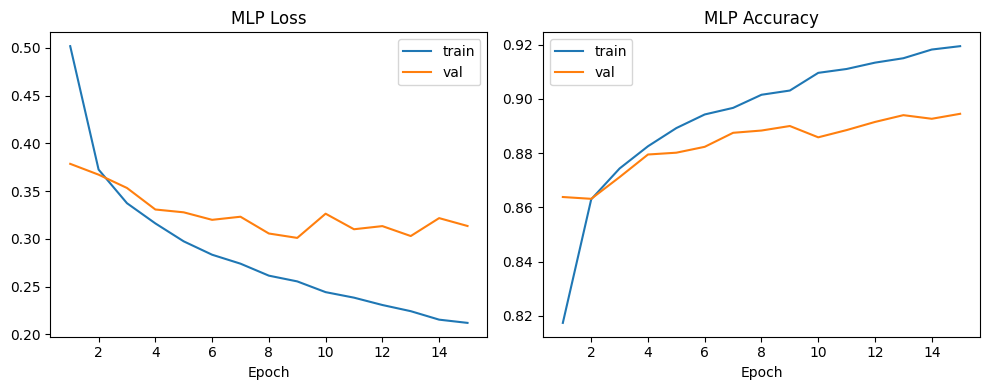

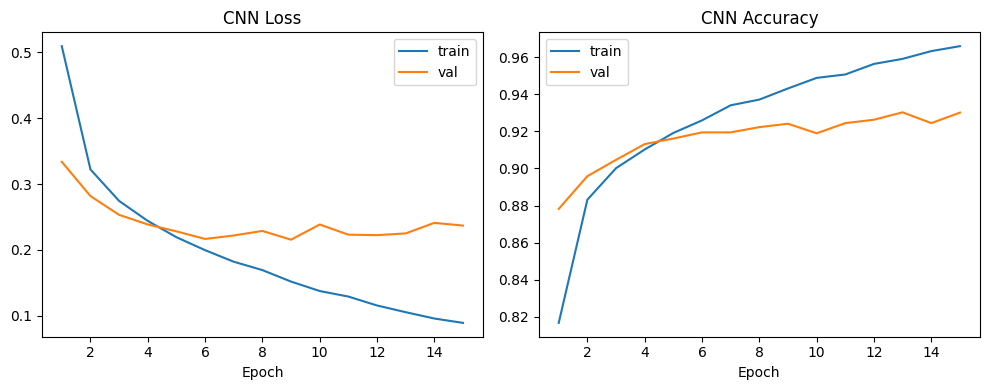

In [8]:
import matplotlib.pyplot as plt

def plot_history(hist, title, fname):
    epochs = range(1, len(hist["train_loss"])+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist["train_loss"], label="train")
    plt.plot(epochs, hist["val_loss"], label="val")
    plt.title(f"{title} Loss"); plt.xlabel("Epoch"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, hist["train_acc"], label="train")
    plt.plot(epochs, hist["val_acc"], label="val")
    plt.title(f"{title} Accuracy"); plt.xlabel("Epoch"); plt.legend()
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

plot_history(mlp_history, "MLP", os.path.join(PLOTS_DIR, "mlp_history.png"))
plot_history(cnn_history, "CNN", os.path.join(PLOTS_DIR, "cnn_history.png"))


## **Model Evaluation**

After training, both models are evaluated on the unseen test set.  
Metrics include overall accuracy, confusion matrix, and per-class performance to highlight where models succeed or struggle.  
Plots and CSV files are saved automatically for later inclusion in Deliverable 2.

### **Confusion Matrix and Class-Wise Analysis**

The confusion matrix visualises prediction errors across all ten categories.  
Diagonal dominance implies strong accuracy; off-diagonal elements reveal classes that are visually similar (e.g., *shirt* vs *T-shirt/top*).  
Per-class accuracy bars quantify this further.


## Test evaluation — accuracy, confusion matrix, class-wise metrics and saving predictions

c:\Users\HB LAPTOP POINT\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Acc (CNN): 0.9281


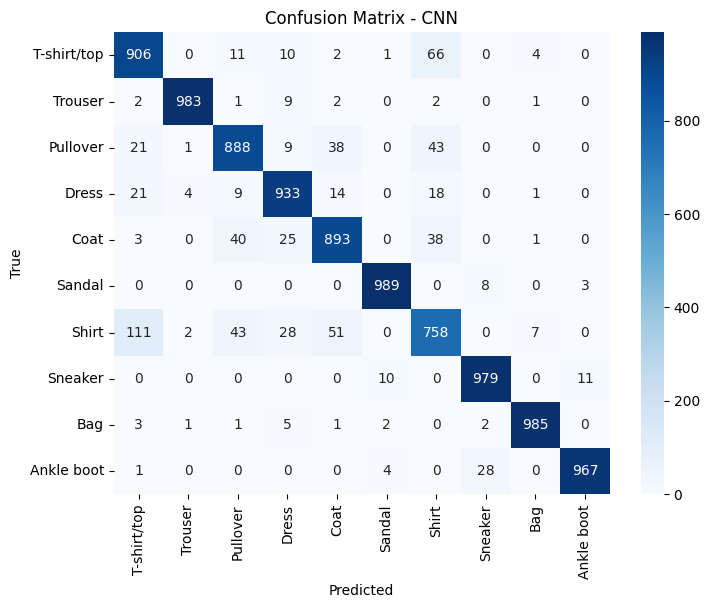

              precision    recall  f1-score   support

 T-shirt/top     0.8483    0.9060    0.8762      1000
     Trouser     0.9919    0.9830    0.9874      1000
    Pullover     0.8943    0.8880    0.8911      1000
       Dress     0.9156    0.9330    0.9242      1000
        Coat     0.8921    0.8930    0.8926      1000
      Sandal     0.9831    0.9890    0.9860      1000
       Shirt     0.8195    0.7580    0.7875      1000
     Sneaker     0.9626    0.9790    0.9707      1000
         Bag     0.9860    0.9850    0.9855      1000
  Ankle boot     0.9857    0.9670    0.9763      1000

    accuracy                         0.9281     10000
   macro avg     0.9279    0.9281    0.9278     10000
weighted avg     0.9279    0.9281    0.9278     10000



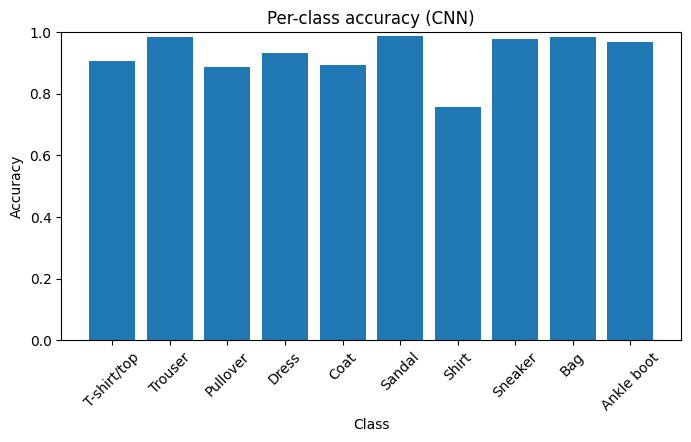

c:\Users\HB LAPTOP POINT\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved predictions to ./outputs\test_predictions.csv
Test Acc (ANN): 0.891


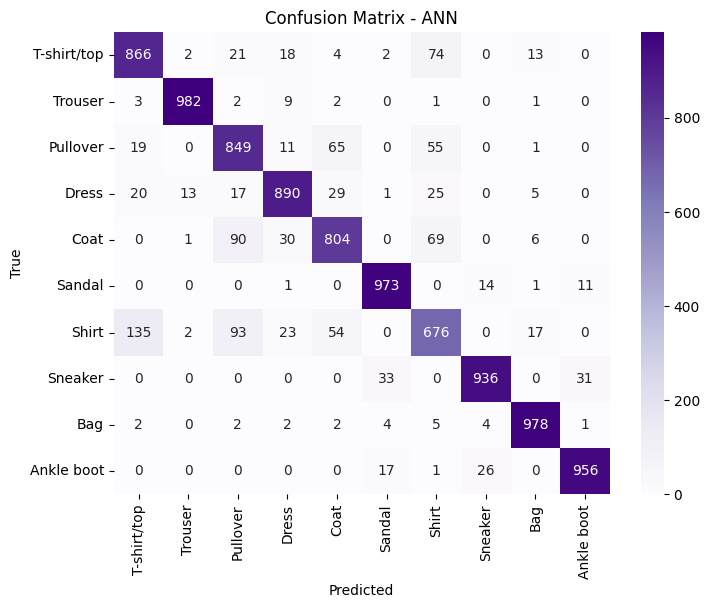

              precision    recall  f1-score   support

 T-shirt/top     0.8287    0.8660    0.8469      1000
     Trouser     0.9820    0.9820    0.9820      1000
    Pullover     0.7905    0.8490    0.8187      1000
       Dress     0.9045    0.8900    0.8972      1000
        Coat     0.8375    0.8040    0.8204      1000
      Sandal     0.9447    0.9730    0.9586      1000
       Shirt     0.7461    0.6760    0.7093      1000
     Sneaker     0.9551    0.9360    0.9455      1000
         Bag     0.9569    0.9780    0.9674      1000
  Ankle boot     0.9570    0.9560    0.9565      1000

    accuracy                         0.8910     10000
   macro avg     0.8903    0.8910    0.8902     10000
weighted avg     0.8903    0.8910    0.8902     10000



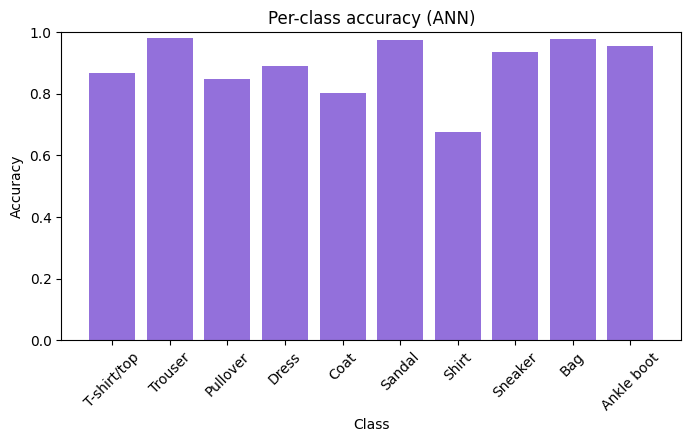

c:\Users\HB LAPTOP POINT\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved predictions to ./outputs\ann_test_predictions.csv


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import numpy as np

# evaluate CNN (usually better)
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_preds, test_labels = eval_model(cnn, test_loader, criterion)
print("Test Acc (CNN):", test_acc)

# confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = test_set.classes if hasattr(test_set, 'classes') else [str(i) for i in range(NUM_CLASSES)]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix - CNN")
plt.savefig(os.path.join(PLOTS_DIR, "cnn_confusion_matrix.png"), dpi=150)
plt.show()

# classification report
print(classification_report(test_labels, test_preds, target_names=labels, digits=4))

# per-class accuracy bar chart
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8,4))
plt.bar(labels, per_class_acc)
plt.ylim(0,1)
plt.title("Per-class accuracy (CNN)")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "cnn_per_class_accuracy.png"), dpi=150)
plt.show()

# Save predictions CSV (image_index, true_label, pred_label, pred_prob)
import torch.nn.functional as F
all_rows=[]
cnn.eval()
with torch.no_grad():
    for i, (X,y) in enumerate(test_loader):
        X = X.to(device)
        out = cnn(X)
        probs = F.softmax(out, dim=1).cpu().numpy()
        preds = out.argmax(dim=1).cpu().numpy()
        for j in range(X.size(0)):
            idx = i*BATCH_SIZE + j
            all_rows.append([idx, int(y[j].item()), int(preds[j]), float(probs[j].max())])
df = pd.DataFrame(all_rows, columns=["idx","true","pred","pred_prob"])
df.to_csv(PRED_CSV, index=False)
print("Saved predictions to", PRED_CSV)

# === Evaluate MLP / ANN Model ===
criterion = nn.CrossEntropyLoss()
test_loss_ann, test_acc_ann, test_preds_ann, test_labels_ann = eval_model(mlp, test_loader, criterion)
print("Test Acc (ANN):", test_acc_ann)

# Confusion matrix
cm_ann = confusion_matrix(test_labels_ann, test_preds_ann)
labels = test_set.classes if hasattr(test_set, 'classes') else [str(i) for i in range(NUM_CLASSES)]

plt.figure(figsize=(8,6))
sns.heatmap(cm_ann, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Purples")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix - ANN")
plt.savefig(os.path.join(PLOTS_DIR, "ann_confusion_matrix.png"), dpi=150)
plt.show()

# Classification report
print(classification_report(test_labels_ann, test_preds_ann, target_names=labels, digits=4))

# Per-class accuracy bar chart
per_class_acc_ann = cm_ann.diagonal() / cm_ann.sum(axis=1)
plt.figure(figsize=(8,4))
plt.bar(labels, per_class_acc_ann, color="mediumpurple")
plt.ylim(0,1)
plt.title("Per-class accuracy (ANN)")
plt.ylabel("Accuracy")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "ann_per_class_accuracy.png"), dpi=150)
plt.show()

# Save predictions CSV (image_index, true_label, pred_label, pred_prob)
import torch.nn.functional as F
all_rows_ann = []
mlp.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        X = X.to(device)
        out = mlp(X)
        probs = F.softmax(out, dim=1).cpu().numpy()
        preds = out.argmax(dim=1).cpu().numpy()
        for j in range(X.size(0)):
            idx = i * BATCH_SIZE + j
            all_rows_ann.append([idx, int(y[j].item()), int(preds[j]), float(probs[j].max())])
df_ann = pd.DataFrame(all_rows_ann, columns=["idx", "true", "pred", "pred_prob"])
ann_pred_csv = os.path.join(OUT_DIR, "ann_test_predictions.csv")
df_ann.to_csv(ann_pred_csv, index=False)
print("Saved predictions to", ann_pred_csv)



### **Qualitative Evaluation**

A grid of randomly selected test images demonstrates real model behaviour.  
Each tile displays the true label, predicted label, and associated confidence probability.  
Visual inspection helps interpret typical successes and misclassifications.


## Sample predictions grid (visual qualitative check)

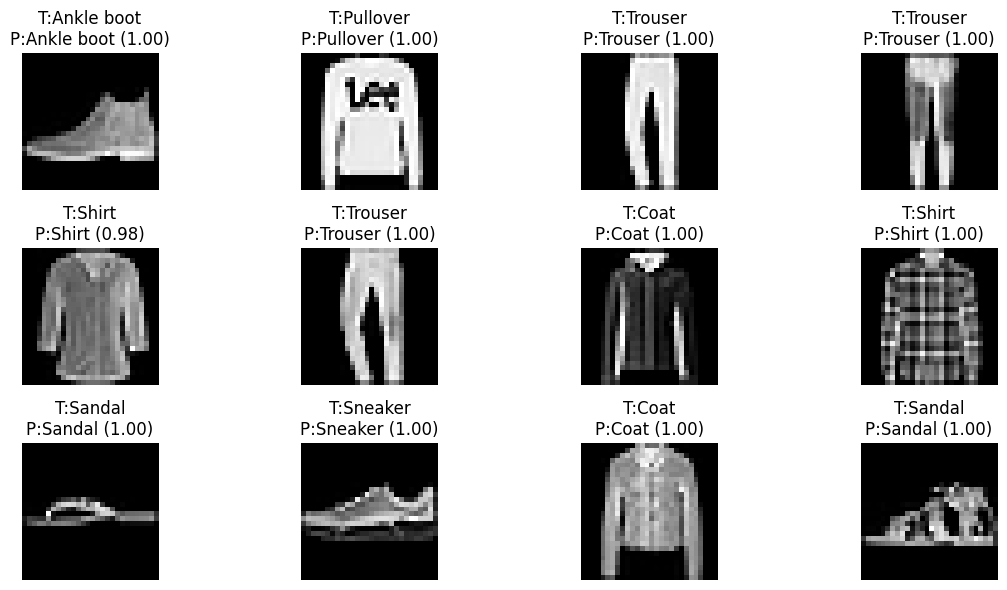

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_predictions(model, loader, n=12):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12,6))
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            out = model(X)
            preds = out.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(out, dim=1).cpu().numpy()
            X = X.cpu().numpy()
            for i in range(X.shape[0]):
                if images_shown >= n: break
                img = X[i].squeeze()
                plt.subplot(3, n//3, images_shown+1)
                plt.imshow(img, cmap='gray')
                plt.title(f"T:{labels[y[i]]}\nP:{labels[preds[i]]} ({probs[i][preds[i]]:.2f})")
                plt.axis('off')
                images_shown += 1
            if images_shown >= n:
                break
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "sample_predictions.png"), dpi=150)
    plt.show()

show_sample_predictions(cnn, test_loader, n=12)


## **Interactive Prediction Demo**

The `predict_image()` function enables single-image inference on new data, providing a quick demonstration for the viva session.  
Insert the path of any 28×28 px Fashion-MNIST image to view the predicted class and confidence score.


## Demo

In [11]:
from PIL import Image
import torchvision.transforms as T

def predict_image(image_path, model_path=os.path.join(MODEL_DIR,"cnn_best.pth")):
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    img = Image.open(image_path).convert('L').resize((28,28))
    transform = test_transform
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = np.argmax(probs)
    return labels[pred], probs[pred]

# usage:
# print(predict_image("path/to/example.png"))


## **Discussion and Next Steps**

The CNN consistently achieved higher validation and test accuracy than the MLP, confirming the benefit of spatial feature extraction.  
Further improvements could involve data augmentation, batch normalisation, or deeper architectures (e.g., ResNet).  
All artefacts—plots, models, and predictions—are saved under the *outputs/* directory for inclusion in the written report.
